# 安装环境

In [ ]:
!pip install transformers datasets peft accelerate bitsandbytes safetensors

# 导入库

In [ ]:
import os, sys
import torch
import datasets
from transformers import (
    AutoTokenizer,
    AutoModelForCausalLM,
    BitsAndBytesConfig,
    DataCollatorForLanguageModeling,
    DataCollatorForSeq2Seq,
    Trainer,
    TrainingArguments,
    GenerationConfig
)
from peft import PeftModel, LoraConfig, prepare_model_for_kbit_training, get_peft_model

# 加载LLaMA 2模型

In [ ]:
### config ###
model_id = "NousResearch/Llama-2-7b-hf" # Chat model： meta-llama/Llama-2–7b-chat-hf
max_length = 512
device_map = "auto"
batch_size = 128
micro_batch_size = 32
gradient_accumulation_steps = batch_size // micro_batch_size

# nf4" use a symmetric quantization scheme with 4 bits precision
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=torch.bfloat16
)

# load model from huggingface
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
    device_map=device_map
)

# load tokenizer from huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "right"

# 输出模型的可训练参数量

In [ ]:
def print_number_of_trainable_model_parameters(model):
    trainable_model_params = 0
    all_model_params = 0
    for _, param in model.named_parameters():
        all_model_params += param.numel()
        if param.requires_grad:
            trainable_model_params += param.numel()
    print(f"trainable model parameters: {trainable_model_params}. All model parameters: {all_model_params} ")
    return trainable_model_params

ori_p = print_number_of_trainable_model_parameters(model)

# 配置LoRA参数

In [ ]:
# LoRA config
model = prepare_model_for_kbit_training(model)
peft_config = LoraConfig(
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    target_modules=["q_proj", "v_proj"],
    bias="none",
    task_type="CAUSAL_LM",
)
model = get_peft_model(model, peft_config)

### compare trainable parameters #
peft_p = print_number_of_trainable_model_parameters(model)
print(f"# Trainable Parameter \nBefore: {ori_p} \nAfter: {peft_p} \nPercentage: {round(peft_p / ori_p * 100, 2)}")

# 输出
# trainable model parameter: 4,194,304

r：更新矩阵的秩，也称为Lora注意力维度。较低的秩导致具有较少可训练参数的较小更新矩阵。增加r（不超过32）将导致更健壮的模型，但同时会导致更高的内存消耗。

lora_lpha：控制lora比例因子

target_modules：是一个模块名称列表，如“q_proj”和“v_proj“，用作LoRA模型的目标。具体的模块名称可能因基础模型而异。

bias：指定是否应训练bias参数。可选参数为：“none”、“all”或“lora_only”。

输出LoRA Adapter的参数，发现只占原模型的不到2%。

# 在微调LLaMA 2之前，先看一下LLaMA 2的生成效果

In [ ]:
### generate ###
prompt = "Write me a poem about Singapore."
inputs = tokenizer(prompt, return_tensors="pt")
generate_ids = model.generate(input_ids=inputs["input_ids"].to("cuda"), max_length=64)
print('\nAnswer: ', tokenizer.decode(generate_ids[0]))
res = tokenizer.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=False)[0]
print(res)

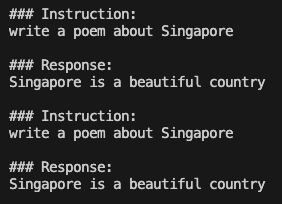

当要求模型写一首关于新加坡的诗时，产生的输出似乎相当模糊和重复，这表明模型很难提供连贯和有意义的回应。

# 微调数据加载

为了方便演示，我们使用开源的databricks/databricks-dolly-15k，数据格式如下：

In [ ]:
{
    'instruction': 'Why can camels survive for long without water?',
    'context': '',
    'response': 'Camels use the fat in their humps to keep them filled with energy and hydration for long periods of time.',
    'category': 'open_qa',
}

要揭秘LLM能力，构建Prompt是至关重要，通常的Prompt形式有三个字段：Instruction、Input（optional）、Response。由于Input是可选的，因为这里设置了两种prompt_template，分别是有Input 的prompt_input和无Input 的prompt_no_input，代码如下：

In [ ]:
max_length = 256
dataset = datasets.load_dataset(
    "databricks/databricks-dolly-15k", split='train'
)

### generate prompt based on template ###
prompt_template = {
    "prompt_input": \
    "Below is an instruction that describes a task, paired with an input that provides further context.\
    Write a response that appropriately completes the request.\
    \n\n### Instruction:\n{instruction}\n\n### Input:\n{input}\n\n### Response:\n",

    "prompt_no_input": \
    "Below is an instruction that describes a task.\
    Write a response that appropriately completes the request.\
    \n\n### Instruction:\n{instruction}\n\n### Response:\n",

    "response_split": "### Response:"
}

def generate_prompt(instruction, input=None, label=None, prompt_template=prompt_template):
    if input:
        res = prompt_template["prompt_input"].format(
            instruction=instruction, input=input)
    else:
        res = prompt_template["prompt_no_input"].format(
            instruction=instruction)
    if label:
        res = f"{res}{label}"
    return res

使用generate_prompt函数把instruction, context和response拼接起来；然后进行tokenize分词处理，转换为input_ids和attention_mask，为了让模型可以预测下一个token，设计了类似input_ids的labels便于右移操作；

In [ ]:
def tokenize(tokenizer, prompt, max_length=max_length, add_eos_token=False):
    result = tokenizer(
        prompt,
        truncation=True,
        max_length=max_length,
        padding=False,
        return_tensors=None)

    result["labels"] = result["input_ids"].copy()
    return result

def generate_and_tokenize_prompt(data_point):
    full_prompt = generate_prompt(
        data_point["instruction"],
        data_point["context"],
        data_point["response"],
    )
    tokenized_full_prompt = tokenize(tokenizer, full_prompt)
    user_prompt = generate_prompt(data_point["instruction"], data_point["context"])
    tokenized_user_prompt = tokenize(tokenizer, user_prompt)
    user_prompt_len = len(tokenized_user_prompt["input_ids"])
    mask_token = [-100] * user_prompt_len
    tokenized_full_prompt["labels"] = mask_token + tokenized_full_prompt["labels"][user_prompt_len:]
    return tokenized_full_prompt

dataset = dataset.train_test_split(test_size=1000, shuffle=True, seed=42)
cols = ["instruction", "context", "response", "category"]
train_data = dataset["train"].shuffle().map(generate_and_tokenize_prompt, remove_columns=cols)
val_data = dataset["test"].shuffle().map(generate_and_tokenize_prompt, remove_columns=cols,)

# 模型训练

In [ ]:
args = TrainingArguments(
    output_dir="./llama-7b-int4-dolly",
    num_train_epochs=20,
    max_steps=200,
    fp16=True,
    optim="paged_adamw_32bit",
    learning_rate=2e-4,
    lr_scheduler_type="constant",
    per_device_train_batch_size=micro_batch_size,
    gradient_accumulation_steps=gradient_accumulation_steps,
    gradient_checkpointing=True,
    group_by_length=False,
    logging_steps=10,
    save_strategy="epoch",
    save_total_limit=3,
    disable_tqdm=False,
)

trainer = Trainer(
    model=model,
    train_dataset=train_data,
    eval_dataset=val_data,
    args=args,
    data_collator=DataCollatorForSeq2Seq(
      tokenizer, pad_to_multiple_of=8, return_tensors="pt", padding=True),
)

# silence the warnings. re-enable for inference!
model.config.use_cache = False
trainer.train()
model.save_pretrained("llama-7b-int4-dolly")

# 模型测试

模型训练几个小时结束后，我们合并预训练模型Llama-2–7b-hf和LoRA参数，我们还是以“Write me a poem about Singapore”测试效果，代码如下：

In [ ]:
# model path and weight
model_id = "NousResearch/Llama-2-7b-hf"
peft_path = "./llama-7b-int4-dolly"

# loading model
model = AutoModelForCausalLM.from_pretrained(
    model_id,
    quantization_config=bnb_config,
    use_cache=False,
    device_map="auto"
)

# loading peft weight
model = PeftModel.from_pretrained(
    model,
    peft_path,
    torch_dtype=torch.float16,
)
model.eval()

# generation config
generation_config = GenerationConfig(
    temperature=0.1,
    top_p=0.75,
    top_k=40,
    num_beams=4, # beam search
)

# generating reply
with torch.no_grad():
    prompt = "Write me a poem about Singapore."
    inputs = tokenizer(prompt, return_tensors="pt")
    generation_output = model.generate(
        input_ids=inputs.input_ids,
        generation_config=generation_config,
        return_dict_in_generate=True,
        output_scores=True,
        max_new_tokens=64,
    )
    print('\nAnswer: ', tokenizer.decode(generation_output.sequences[0]))

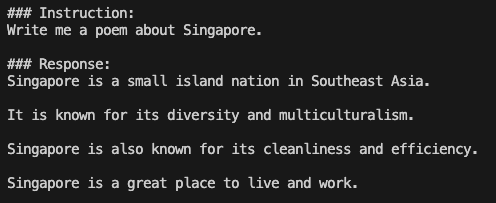

生成模型中参数temperature、top-k、top-p和num_beam含义可以参考：https://github.com/ArronAI007/Awesome-AGI/blob/main/LLM%E4%B9%8BGenerate%E4%B8%AD%E5%8F%82%E6%95%B0%E8%A7%A3%E8%AF%BB.ipynb